In [1]:
import sys
sys.path.append('../')
import numpy as np
np.set_printoptions(precision=2)
import pandas as pd
from statsmodels.tsa.arima_model import ARIMA as ARIMA_sm
from gtime.preprocessing import TimeSeriesPreparation
from gtime.time_series_models import ARIMA, AR
from sklearn.compose import make_column_selector
from gtime.feature_extraction import Shift
from sklearn.metrics import mean_squared_error
from scipy.stats import normaltest
import matplotlib.pyplot as plt
from gtime.stat_tools.mle_estimate import _run_css, _run_mle
%matplotlib inline  

## TIme series

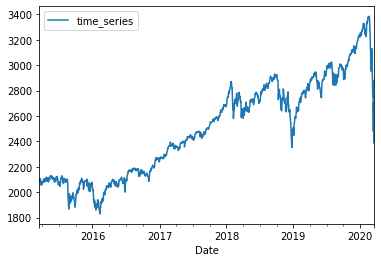

In [2]:
df_sp = pd.read_csv('https://storage.googleapis.com/l2f-open-models/giotto-time/examples/data/^GSPC.csv', parse_dates=['Date'])
df_close = df_sp.set_index('Date')['Close']
time_series_preparation = TimeSeriesPreparation()
df_real = time_series_preparation.transform(df_close)

df_real.plot();

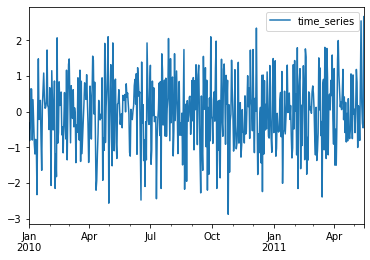

In [3]:
df_white = pd.DataFrame(np.random.standard_normal(500))
time_series_preparation = TimeSeriesPreparation(start='01-01-2010', freq='1D')
df_white = time_series_preparation.transform(df_white)

df_white.plot();

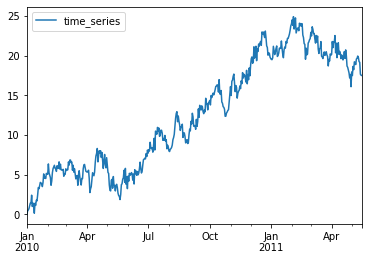

In [4]:
arm_np = np.zeros(501)
mean = 0.0
ar = -.4
ma = -.7
eps = np.random.standard_normal()
for i in range(1, 501):
    arm_np[i] = mean + ar * arm_np[i-1] + ma * eps
    eps = np.random.standard_normal()
arima_np = arm_np.cumsum()
df_arima = pd.DataFrame(arima_np)
time_series_preparation = TimeSeriesPreparation(start='01-01-2010', freq='1D')
df_arima = time_series_preparation.transform(df_arima)
df_arima.plot()

## Test functions

In [5]:
def train_test_plot(df_train, df_test, df_pred, train_error, test_error):
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    df_train.plot(ax=ax[0])
    df_test.plot(ax=ax[0])
    df_pred.plot(ax=ax[0])
    ax[1].hist(train_error)
    ax[2].hist(test_error)

In [6]:
def run_giotto_ar(df, test_size, p):
    model = AR(horizon=test_size, p=p)
    df_train = df
    df_test = df.iloc[-test_size:]
    model = model.fit(df_train)
    pred_g = model.predict()
    y_pred = pd.DataFrame(pred_g.values[0], index=df_test.index, columns=['time_series'])
    print('Basic AR results results:')
    print(f'Fitted parameters: mu={model.model.estimators_[0].intercept_:.2f}, p={model.model.estimators_[0].coef_}')
    print(f'RMSE: {mean_squared_error(y_pred, df_test.values):.2f}\n')
    return model.model.estimators_[0].coef_

mar = run_giotto_ar(df_white, 100, 4)
mar

Basic AR results results:
Fitted parameters: mu=-0.06, p=[-0.08 -0.03 -0.04  0.06]
RMSE: 1.08



array([-0.08, -0.03, -0.04,  0.06])

Giotto results css:
Fitted parameters: mu=-0.06, p=[-0.07 -0.04 -0.04  0.06], q=[]
AR roots abs:[2.46 1.89 1.98 1.98]
MA roots abs:[]
Train error mean: 0.00, std: 0.97
LL: 551.06
RMSE: 1.06



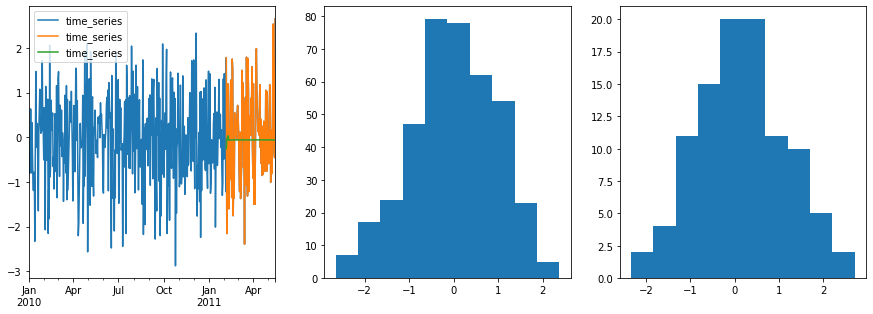

In [9]:
def run_giotto_arima(df, test_size, order, method='css-mle', plot=True):
    model = ARIMA(horizon=test_size, order=order, method=method)
    df_train = df
    df_test = df.iloc[-test_size:]
    model.fit(df_train)
    pred_g = model.predict(df_test.iloc[[0]])
    y_pred = pd.DataFrame(pred_g.values[0], index=df_test.index, columns=['time_series'])
    phi = model.model.phi_
    theta = model.model.theta_
    mu = model.model.mu_
    train_errors = model.model.errors_
    print(f'Giotto results {method}:')
    print(f'Fitted parameters: mu={mu:.2f}, p={phi}, q={theta}')
    print(f'AR roots abs:{np.abs(np.roots(np.r_[-phi[::-1], 1.0]))}')
    print(f'MA roots abs:{np.abs(np.roots(np.r_[theta[::-1], 1.0]))}')
    print(f'Train error mean: {train_errors.mean():.2f}, std: {train_errors.std():.2f}')
    print(f'LL: {model.model.model.ml:.2f}')
    print(f'RMSE: {mean_squared_error(y_pred, df_test.values):.2f}\n')
#     print(normaltest(train_errors))
    if plot:
        test_errors = df_test -  y_pred
        train_test_plot(df_train, df_test, y_pred, train_errors, test_errors.values)
    return mu, phi, theta
    
mu, phi, theta = run_giotto_arima(df_white, 100, (4, 0, 0), 'css')

Statsmodels results css:
Fitted parameters: mu=-0.06, p=[-0.07 -0.04 -0.04  0.06], q=[]
AR roots abs:[1.89 1.98 1.98 2.46]
MA roots abs:[]
Train error mean: -0.00, std: 0.97
LL: 551.06
RMSE: 1.05



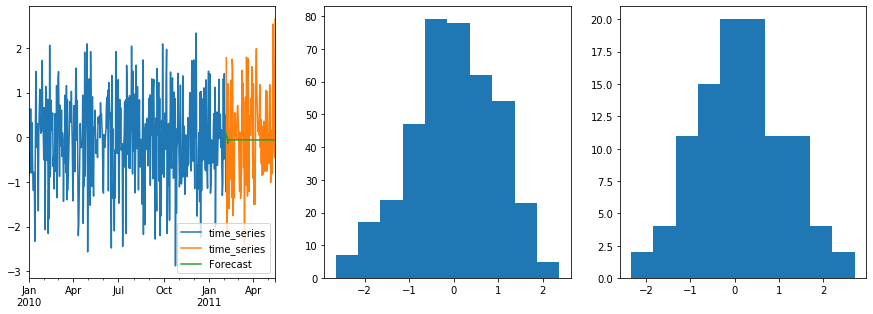

In [10]:
def run_sm(df, test_size, order, method='css-mle', plot=True):
    df_train = df.iloc[:-test_size]
    df_test = df.iloc[-test_size:]
    m2 = ARIMA_sm(df_train, order)
    f = m2.fit(method=method)
    y2, _, _ = f.forecast(test_size)
    y_pred = pd.DataFrame(y2, index=df_test.index, columns=['Forecast'])
    print(f'Statsmodels results {method}:')
    print(f'Fitted parameters: mu={f.params.const:.2f}, p={f.arparams}, q={f.maparams}')
    print(f'AR roots abs:{np.abs(f.arroots)}')
    print(f'MA roots abs:{np.abs(f.maroots)}')
    train_errors = m2.geterrors(f.params)
    print(f'Train error mean: {train_errors.mean():.2f}, std: {train_errors.std():.2f}')
    print(f'LL: {-f.llf:.2f}')
    print(f'RMSE: {mean_squared_error(y2, df_test.values):.2f}\n')
#     print(normaltest(train_errors))
    if plot:
        test_errors = df_test.values.flatten() -  y2
        train_test_plot(df_train, df_test, y_pred, train_errors, test_errors)
    return f, m2

f = run_sm(df_white, 100, (4, 0, 0), 'css')

## Simple AR check

In [12]:
df = df_white
run_giotto_ar(df, 100, 2)
run_sm(df, 100, (2, 0, 0), 'css', plot=False);
run_sm(df, 100, (2, 0, 0), 'mle', plot=False);
run_giotto_arima(df, 100, (2, 0, 0), 'css', plot=False);
run_giotto_arima(df, 100, (2, 0, 0), 'mle', plot=False);

Basic AR results results:
Fitted parameters: mu=0.01, p=[-0.03 -0.06]
RMSE: 0.90

Statsmodels results css:
Fitted parameters: mu=0.01, p=[-0.03 -0.06], q=[]
AR roots abs:[3.93 3.93]
MA roots abs:[]
Train error mean: 0.00, std: 1.02
RMSE: 0.89

Statsmodels results mle:
Fitted parameters: mu=0.02, p=[-0.02 -0.07], q=[]
AR roots abs:[3.92 3.92]
MA roots abs:[]
Train error mean: 0.00, std: 1.03
RMSE: 0.89

Giotto results css:
Fitted parameters: mu=0.01, p=[-0.03 -0.06], q=[]
AR roots abs:[3.93 3.93]
MA roots abs:[]
Train error mean: 0.00, std: 1.02
RMSE: 0.89



../gtime/stat_tools/tools.py:44: RuntimeWarning: overflow encountered in multiply
  return -0.5 * (np.log(2 * np.pi * np.abs(F)) + mat_square(np.linalg.inv(F), nu))


Giotto results mle:
Fitted parameters: mu=0.02, p=[-0.02 -0.07], q=[]
AR roots abs:[3.92 3.92]
MA roots abs:[]
Train error mean: -0.00, std: 1.03
RMSE: 0.89



In [13]:
df = df_real
run_giotto_ar(df, 100, 2)
run_sm(df, 100, (2, 0, 0), 'css', plot=False);
run_sm(df, 100, (2, 0, 0), 'mle', plot=False);
run_giotto_arima(df, 100, (2, 0, 0), 'css', plot=False);
run_giotto_arima(df, 100, (2, 0, 0), 'mle', plot=False);

Basic AR results results:
Fitted parameters: mu=3.58, p=[0.98 0.02]
RMSE: 44772.60

Statsmodels results css:
Fitted parameters: mu=3261.40, p=[0.98 0.02], q=[]
AR roots abs:[ 1.   49.74]
MA roots abs:[]
Train error mean: -0.02, std: 20.81
RMSE: 52639.91

Statsmodels results mle:
Fitted parameters: mu=2494.44, p=[0.98 0.02], q=[]
AR roots abs:[ 1.   53.84]
MA roots abs:[]
Train error mean: 0.37, std: 23.82
RMSE: 67607.63

Giotto results css:
Fitted parameters: mu=3147.93, p=[0.98 0.02], q=[]
AR roots abs:[50.01  1.  ]
MA roots abs:[]
Train error mean: -0.01, std: 20.81
RMSE: 53481.82



../gtime/stat_tools/tools.py:44: RuntimeWarning: overflow encountered in multiply
  return -0.5 * (np.log(2 * np.pi * np.abs(F)) + mat_square(np.linalg.inv(F), nu))


Giotto results mle:
Fitted parameters: mu=2442.22, p=[0.98 0.02], q=[]
AR roots abs:[46.71  1.  ]
MA roots abs:[]
Train error mean: 0.79, std: 20.80
RMSE: 54647.72



## Simple ARI check

In [11]:
df = df_white
run_sm(df, 100, (2, 1, 0), 'css', plot=False);
run_sm(df, 100, (2, 1, 0), 'mle', plot=False);
run_giotto_arima(df, 100, (2, 1, 0), 'css', plot=False);
run_giotto_arima(df, 100, (2, 1, 0), 'mle', plot=False);

Statsmodels results css:
Fitted parameters: mu=0.00, p=[-0.69 -0.34], q=[]
AR roots abs:[1.73 1.73]
MA roots abs:[]
Train error mean: 0.00, std: 1.15
LL: 619.73
RMSE: 1.30

Statsmodels results mle:
Fitted parameters: mu=0.00, p=[-0.69 -0.33], q=[]
AR roots abs:[1.73 1.73]
MA roots abs:[]
Train error mean: -0.00, std: 1.15
LL: 622.19
RMSE: 1.31

Giotto results css:
Fitted parameters: mu=-0.00, p=[-0.69 -0.34], q=[]
AR roots abs:[1.73 1.73]
MA roots abs:[]
Train error mean: -0.00, std: 1.15
LL: 618.15
RMSE: 1.44

Giotto results mle:
Fitted parameters: mu=0.00, p=[-0.69 -0.33], q=[]
AR roots abs:[1.73 1.73]
MA roots abs:[]
Train error mean: 0.00, std: 1.15
LL: 621.13
RMSE: 1.52



In [12]:
df = df_real
run_sm(df, 100, (2, 1, 0), 'css', plot=False);
run_sm(df, 100, (2, 1, 0), 'mle', plot=False);
run_giotto_arima(df, 100, (2, 1, 0), 'css', plot=False);
run_giotto_arima(df, 100, (2, 1, 0), 'mle', plot=False);

Statsmodels results css:
Fitted parameters: mu=0.77, p=[-0.02 -0.06], q=[]
AR roots abs:[4.23 4.23]
MA roots abs:[]
Train error mean: 0.00, std: 20.78
LL: 5147.77
RMSE: 46983.52

Statsmodels results mle:
Fitted parameters: mu=0.77, p=[-0.02 -0.06], q=[]
AR roots abs:[4.23 4.23]
MA roots abs:[]
Train error mean: 0.00, std: 20.77
LL: 5156.18
RMSE: 46931.59

Giotto results css:
Fitted parameters: mu=0.77, p=[-0.02 -0.06], q=[]
AR roots abs:[4.22 4.22]
MA roots abs:[]
Train error mean: 0.00, std: 20.79
LL: 5143.79
RMSE: 45117.28



../gtime/stat_tools/tools.py:44: RuntimeWarning: overflow encountered in multiply
  return -0.5 * (np.log(2 * np.pi * np.abs(F)) + mat_square(np.linalg.inv(F), nu))


Giotto results mle:
Fitted parameters: mu=0.78, p=[-0.02 -0.06], q=[]
AR roots abs:[4.23 4.23]
MA roots abs:[]
Train error mean: -0.01, std: 20.77
LL: 5152.09
RMSE: 45023.85



In [14]:
df = df_arima
run_sm(df, 100, (1, 1, 0), 'css', plot=False);
run_sm(df, 100, (1, 1, 0), 'mle', plot=False);
run_giotto_arima(df, 100, (1, 1, 0), 'css', plot=False);
run_giotto_arima(df, 100, (1, 1, 0), 'mle', plot=False);

Statsmodels results css:
Fitted parameters: mu=0.06, p=[-0.34], q=[]
AR roots abs:[2.9]
MA roots abs:[]
Train error mean: 0.00, std: 0.71
LL: 428.85
RMSE: 47.45

Statsmodels results mle:
Fitted parameters: mu=0.06, p=[-0.34], q=[]
AR roots abs:[2.91]
MA roots abs:[]
Train error mean: 0.00, std: 0.71
LL: 429.62
RMSE: 47.83

Giotto results css:
Fitted parameters: mu=0.06, p=[-0.34], q=[]
AR roots abs:[2.9]
MA roots abs:[]
Train error mean: 0.00, std: 0.71
LL: 428.24
RMSE: 57.48

Giotto results mle:
Fitted parameters: mu=0.06, p=[-0.34], q=[]
AR roots abs:[2.91]
MA roots abs:[]
Train error mean: -0.00, std: 0.71
LL: 428.88
RMSE: 57.53



## Full ARIMA check

In [15]:
df = df_white
run_sm(df, 100, (2, 1, 3), 'css', plot=False);
run_sm(df, 100, (2, 1, 3), 'mle', plot=False);
run_giotto_arima(df, 100, (2, 1, 3), 'css', plot=False);
run_giotto_arima(df, 100, (2, 1, 3), 'mle', plot=False);

Statsmodels results css:
Fitted parameters: mu=0.00, p=[-1.13 -0.93], q=[ 0.16 -0.14 -0.96]
AR roots abs:[1.04 1.04]
MA roots abs:[1.01 1.01 1.02]
Train error mean: 0.03, std: 0.98
LL: 555.94
RMSE: 1.04



/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
../gtime/stat_tools/mle_estimate.py:109: RuntimeWarning: invalid value encountered in double_scalars
  loglikelihood = -nobs / 2. * (np.log(2 * np.pi * sigma2)) - ssr / (2. * sigma2)


Statsmodels results mle:
Fitted parameters: mu=0.00, p=[-1.13 -0.95], q=[ 0.15 -0.15 -1.  ]
AR roots abs:[1.03 1.03]
MA roots abs:[1. 1. 1.]
Train error mean: 0.03, std: 0.97
LL: 555.52
RMSE: 1.05

Giotto results css:
Fitted parameters: mu=-0.00, p=[-0.86 -0.46], q=[-0.16 -0.37 -0.48]
AR roots abs:[1.47 1.47]
MA roots abs:[1.45 1.45 1.  ]
Train error mean: 0.00, std: 0.98
LL: 553.32
RMSE: 1.90



../gtime/stat_tools/tools.py:44: RuntimeWarning: overflow encountered in multiply
  return -0.5 * (np.log(2 * np.pi * np.abs(F)) + mat_square(np.linalg.inv(F), nu))


Giotto results mle:
Fitted parameters: mu=0.00, p=[0.   0.83], q=[-1.1  -0.77  0.87]
AR roots abs:[1.1  1.09]
MA roots abs:[1.13 1.01 1.01]
Train error mean: 0.02, std: 0.97
LL: 553.24
RMSE: 464.99



In [17]:
df = df_real
run_sm(df, 100, (4, 1, 3), 'css', plot=False);
run_sm(df, 100, (4, 1, 3), 'mle', plot=False);
run_giotto_arima(df, 100, (4, 1, 3), 'css', plot=False);
run_giotto_arima(df, 100, (4, 1, 3), 'mle', plot=False);

Statsmodels results css:
Fitted parameters: mu=0.80, p=[ 0.29  0.41 -0.46 -0.04], q=[-0.31 -0.45  0.5 ]
AR roots abs:[ 1.22  1.29  1.29 12.28]
MA roots abs:[1.15 1.31 1.31]
Train error mean: -0.00, std: 20.75
RMSE: 46905.24

Statsmodels results mle:
Fitted parameters: mu=0.81, p=[ 0.38 -0.2   0.77 -0.02], q=[-0.4   0.15 -0.72]
AR roots abs:[ 1.03  1.13  1.13 38.81]
MA roots abs:[1.01 1.17 1.17]
Train error mean: -0.10, std: 20.68
RMSE: 49264.60



../gtime/stat_tools/mle_estimate.py:109: RuntimeWarning: invalid value encountered in double_scalars
  loglikelihood = -nobs / 2. * (np.log(2 * np.pi * sigma2)) - ssr / (2. * sigma2)


Giotto results css:
Fitted parameters: mu=0.82, p=[-0.29  0.52 -0.01  0.  ], q=[ 0.27 -0.58  0.01]
AR roots abs:[17.55 17.55  1.71  1.13]
MA roots abs:[43.04  1.6   1.09]
Train error mean: 0.01, std: 20.74
RMSE: 44561.96

Giotto results mle:
Fitted parameters: mu=0.78, p=[0.62 0.36 0.99 0.6 ], q=[0.31 0.59 0.91]
AR roots abs:[1.88 1.15 1.15 0.67]
MA roots abs:[1.16 0.97 0.97]
Train error mean: -0.45, std: 125.04
RMSE: 757387684712546369192682324501783904256.00



In [ ]:
df = df_arima
run_sm(df, 100, (2, 1, 3), 'css', plot=False);
run_sm(df, 100, (2, 1, 3), 'mle', plot=False);
run_giotto_arima(df, 100, (2, 1, 3), 'css', plot=False);
run_giotto_arima(df, 100, (2, 1, 3), 'mle', plot=False);

Statsmodels results css:
Fitted parameters: mu=0.06, p=[-0.82  0.11], q=[ 0.5  -0.23  0.14]
AR roots abs:[1.06 8.49]
MA roots abs:[1.09 2.55 2.55]
Train error mean: -0.00, std: 0.71
LL: 426.91
RMSE: 46.56

Statsmodels results mle:
Fitted parameters: mu=0.06, p=[-0.87  0.07], q=[ 0.54 -0.2   0.13]
AR roots abs:[ 1.06 14.07]
MA roots abs:[1.09 2.65 2.65]
Train error mean: 0.00, std: 0.71
LL: 428.26
RMSE: 46.89



../gtime/stat_tools/mle_estimate.py:109: RuntimeWarning: invalid value encountered in double_scalars
  loglikelihood = -nobs / 2. * (np.log(2 * np.pi * sigma2)) - ssr / (2. * sigma2)


Giotto results css:
Fitted parameters: mu=0.06, p=[-0.87  0.07], q=[ 0.54 -0.2   0.13]
AR roots abs:[14.1   1.06]
MA roots abs:[2.65 2.65 1.09]
Train error mean: 0.00, std: 0.71
LL: 426.28
RMSE: 51.69



../gtime/stat_tools/tools.py:44: RuntimeWarning: overflow encountered in multiply
  return -0.5 * (np.log(2 * np.pi * np.abs(F)) + mat_square(np.linalg.inv(F), nu))


## Performance tests

In [20]:
%prun run_giotto_arima(df_real, 100, (2, 0, 3), 'mle', plot=False);

../gtime/stat_tools/mle_estimate.py:37: RuntimeWarning: invalid value encountered in true_divide
  gain = multi_dot([p_hat, np.transpose(Z)]) / F
../gtime/stat_tools/tools.py:26: RuntimeWarning: overflow encountered in double_scalars
  return -0.5 * (np.log(2 * np.pi * np.abs(F)) + nu * nu / F)


Giotto results mle:
Fitted parameters: mu=2507.20, p=[0.15 0.84], q=[ 0.83 -0.07 -0.02]
AR roots abs:[1.18 1.  ]
MA roots abs:[8.58 5.8  1.13]
Train error mean: 0.74, std: 20.72
RMSE: 64751.18

 

In [7]:
from gtime.stat_tools.mle_estimate import alt_likelihood
%load_ext line_profiler

In [8]:
x = df_real.values.flatten()
phi = np.array([0.15, 0.84, 0.0])
theta = np.array([0.83, -0.07, -0.02])

In [9]:
%lprun -f alt_likelihood for i in range(100): alt_likelihood(x, mu=2507.20, sigma=20.0, phi=phi, theta=theta)

In [11]:
from scipy.linalg import toeplitz

In [18]:
t = toeplitz(range(100, 0, -1))

In [106]:
(df_real.index[1].start_time - df_real.index[0].end_time).value.__class__

int

In [111]:
df_real.index[0]

Period('2015-03-18', 'D')

In [113]:
pd.period_range(end=df_real.index[0], periods=3)[:-1]

PeriodIndex(['2015-03-16', '2015-03-17'], dtype='period[D]', freq='D')

In [103]:
(df_real.index[2].start_time - df_real.index[0].end_time).value

86400000000001

In [90]:
%timeit for i in range(100000): np.linalg.multi_dot([xx, t, xx])

11.3 s ± 237 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [91]:
%timeit for i in range(100000): linalg.blas.dsymm(1.0, xx, t)

7.27 s ± 227 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [87]:
%timeit np.matmul(xx, t)

55.2 µs ± 530 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [77]:
%prun np.dot(np.dot(xx, t), xx)

In [29]:
np.dot(np.dot(xx, t), xx)

array([[173518.33, 184138.57, 195430.05, ..., 180610.82, 162839.47,
        182269.44],
       [171487.71, 181496.28, 193189.  , ..., 178313.69, 161000.42,
        179761.59],
       [153540.49, 163463.09, 173067.35, ..., 160168.91, 144275.16,
        161858.39],
       ...,
       [167665.29, 177995.47, 188855.18, ..., 174580.1 , 157384.11,
        176198.68],
       [161901.05, 171190.13, 182149.99, ..., 168116.75, 151713.31,
        169600.71],
       [160761.6 , 170391.67, 181125.24, ..., 167311.9 , 150950.71,
        168768.25]])

In [47]:
from scipy import linalg

In [84]:
%prun for i in range(100000): da =  np.dot(xx, t)
da

array([[2722.94, 2776.2 , 2828.05, ..., 2772.06, 2720.95, 2669.23],
       [2601.58, 2652.88, 2703.33, ..., 2848.92, 2798.72, 2747.1 ],
       [2561.15, 2608.06, 2653.8 , ..., 2338.04, 2291.28, 2244.14],
       ...,
       [2652.12, 2703.6 , 2754.77, ..., 2688.26, 2638.04, 2586.51],
       [2385.6 , 2434.45, 2482.42, ..., 2673.55, 2625.4 , 2576.96],
       [2504.98, 2554.66, 2603.21, ..., 2649.7 , 2600.98, 2550.98]])

In [83]:
%prun for i in range(100000): dd = linalg.blas.dsymm(1.0, xx, t)
dd

array([[2722.94, 2776.2 , 2828.05, ..., 2772.06, 2720.95, 2669.23],
       [2588.95, 2640.37, 2690.95, ..., 2848.54, 2798.47, 2746.97],
       [2511.12, 2557.67, 2603.91, ..., 2336.09, 2289.84, 2243.21],
       ...,
       [2583.65, 2633.26, 2681.23, ..., 2612.82, 2563.99, 2513.86],
       [2279.84, 2324.82, 2368.39, ..., 2414.84, 2370.23, 2325.33],
       [2647.04, 2696.05, 2743.72, ..., 2571.82, 2521.89, 2471.27]])

In [44]:
np.show_config()

blas_mkl_info:
  NOT AVAILABLE
blis_info:
  NOT AVAILABLE
openblas_info:
    libraries = ['openblas', 'openblas']
    library_dirs = ['/usr/local/lib']
    language = c
    define_macros = [('HAVE_CBLAS', None)]
blas_opt_info:
    libraries = ['openblas', 'openblas']
    library_dirs = ['/usr/local/lib']
    language = c
    define_macros = [('HAVE_CBLAS', None)]
lapack_mkl_info:
  NOT AVAILABLE
openblas_lapack_info:
    libraries = ['openblas', 'openblas']
    library_dirs = ['/usr/local/lib']
    language = c
    define_macros = [('HAVE_CBLAS', None)]
lapack_opt_info:
    libraries = ['openblas', 'openblas']
    library_dirs = ['/usr/local/lib']
    language = c
    define_macros = [('HAVE_CBLAS', None)]


In [39]:
chol_mul(t, xx)

array([[ 95896.38, 110670.59, 109462.1 , ..., 104493.93,  91988.74,
        110156.72],
       [110670.59, 129953.65, 127219.35, ..., 122005.26, 107148.83,
        129229.2 ],
       [109462.1 , 127219.35, 125497.88, ..., 119929.8 , 105566.06,
        126626.02],
       ...,
       [104493.93, 122005.26, 119929.8 , ..., 114863.81, 100969.53,
        121450.67],
       [ 91988.74, 107148.83, 105566.06, ..., 100969.53,  88899.95,
        106667.33],
       [110156.72, 129229.2 , 126626.02, ..., 121450.67, 106667.33,
        128762.81]])

In [46]:
%timeit chol_mul(t, xx)

69.3 µs ± 420 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [45]:
from scipy.linalg import cholesky
def chol_mul(t, xx):
    root = cholesky(t)
#     z = np.dot(root, xx)
    return root

In [20]:
xx = np.random.random((100, 100))

In [19]:
%prun run_sm(df_real, 100, (2, 0, 3), 'mle', plot=False);

Statsmodels results mle:
Fitted parameters: mu=2498.75, p=[0.15 0.85], q=[ 0.83 -0.07 -0.02]
AR roots abs:[1.   1.18]
MA roots abs:[1.13 5.79 8.57]
Train error mean: 0.40, std: 23.82
RMSE: 67014.84

 

In [121]:
%timeit run_giotto_arima(df, 100, (2, 0, 3), 'mle', plot=False);

../gtime/stat_tools/tools.py:7: RuntimeWarning: overflow encountered in multiply
  return -0.5 * (np.log(2 * np.pi * np.abs(F)) + mat_square(np.linalg.inv(F), nu))


Giotto results mle:
Fitted parameters: mu=0.84, p=[ 1.98 -0.98], q=[-1.46  0.67 -0.22]
AR roots abs:[1.01 1.01]
MA roots abs:[2.15 2.15 1.  ]
Train error mean: 0.02, std: 0.68
RMSE: 14.71



../gtime/stat_tools/tools.py:7: RuntimeWarning: overflow encountered in multiply
  return -0.5 * (np.log(2 * np.pi * np.abs(F)) + mat_square(np.linalg.inv(F), nu))


Giotto results mle:
Fitted parameters: mu=1.30, p=[0.72 0.25], q=[-0.19  0.13  0.03]
AR roots abs:[3.92 1.03]
MA roots abs:[6.89 2.37 2.37]
Train error mean: 0.01, std: 0.69
RMSE: 2.59



../gtime/stat_tools/tools.py:7: RuntimeWarning: overflow encountered in multiply
  return -0.5 * (np.log(2 * np.pi * np.abs(F)) + mat_square(np.linalg.inv(F), nu))


Giotto results mle:
Fitted parameters: mu=1.30, p=[0.72 0.25], q=[-0.19  0.13  0.03]
AR roots abs:[3.92 1.03]
MA roots abs:[6.9  2.37 2.37]
Train error mean: 0.01, std: 0.69
RMSE: 2.60



../gtime/stat_tools/tools.py:7: RuntimeWarning: overflow encountered in multiply
  return -0.5 * (np.log(2 * np.pi * np.abs(F)) + mat_square(np.linalg.inv(F), nu))


Giotto results mle:
Fitted parameters: mu=1.30, p=[0.72 0.25], q=[-0.19  0.13  0.03]
AR roots abs:[3.92 1.03]
MA roots abs:[6.9  2.37 2.37]
Train error mean: 0.01, std: 0.69
RMSE: 2.60



../gtime/stat_tools/tools.py:7: RuntimeWarning: overflow encountered in multiply
  return -0.5 * (np.log(2 * np.pi * np.abs(F)) + mat_square(np.linalg.inv(F), nu))


Giotto results mle:
Fitted parameters: mu=1.30, p=[0.72 0.25], q=[-0.19  0.13  0.03]
AR roots abs:[3.92 1.03]
MA roots abs:[6.88 2.37 2.37]
Train error mean: 0.01, std: 0.69
RMSE: 2.60



../gtime/stat_tools/tools.py:7: RuntimeWarning: overflow encountered in multiply
  return -0.5 * (np.log(2 * np.pi * np.abs(F)) + mat_square(np.linalg.inv(F), nu))


Giotto results mle:
Fitted parameters: mu=1.30, p=[0.72 0.25], q=[-0.19  0.13  0.03]
AR roots abs:[3.92 1.03]
MA roots abs:[6.89 2.37 2.37]
Train error mean: 0.01, std: 0.69
RMSE: 2.60



../gtime/stat_tools/tools.py:7: RuntimeWarning: overflow encountered in multiply
  return -0.5 * (np.log(2 * np.pi * np.abs(F)) + mat_square(np.linalg.inv(F), nu))


Giotto results mle:
Fitted parameters: mu=1.30, p=[0.72 0.25], q=[-0.19  0.13  0.03]
AR roots abs:[3.93 1.03]
MA roots abs:[6.92 2.37 2.37]
Train error mean: 0.01, std: 0.69
RMSE: 2.59



../gtime/stat_tools/tools.py:7: RuntimeWarning: overflow encountered in multiply
  return -0.5 * (np.log(2 * np.pi * np.abs(F)) + mat_square(np.linalg.inv(F), nu))


Giotto results mle:
Fitted parameters: mu=1.10, p=[ 0.32 -0.52], q=[0.57 0.92 0.69]
AR roots abs:[1.38 1.38]
MA roots abs:[1.45 1.   1.  ]
Train error mean: 0.01, std: 1.31
RMSE: 6.31

11.9 s ± 4.09 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [53]:
df = df_white
run_sm(df, 100, (0, 0, 3), 'css', plot=False);
run_sm(df, 100, (0, 0, 3), 'mle', plot=False);
run_giotto_arima(df, 100, (0, 0, 3), 'css', plot=False);
run_giotto_arima(df, 100, (0, 0, 3), 'mle', plot=False);

Statsmodels results css:
Fitted parameters: mu=0.01, p=[], q=[-0.01 -0.06  0.  ]
AR roots abs:[]
MA roots abs:[3.75 6.16 8.75]
Train error mean: 0.00, std: 0.98
RMSE: 1.26

Statsmodels results mle:
Fitted parameters: mu=0.01, p=[], q=[-0.01 -0.06  0.  ]
AR roots abs:[]
MA roots abs:[3.75 6.27 8.54]
Train error mean: 0.00, std: 0.98
RMSE: 1.26



../gtime/stat_tools/mle_estimate.py:59: RuntimeWarning: invalid value encountered in double_scalars
  loglikelihood = -nobs / 2. * (np.log(2 * np.pi * sigma2)) - ssr / (2. * sigma2)


Giotto results css:
Fitted parameters: mu=0.01, p=[], q=[-0.01 -0.06  0.  ]
AR roots abs:[]
MA roots abs:[10.56  5.48  3.75]
Train error mean: 0.00, std: 0.98
RMSE: 1.26

Giotto results mle:
Fitted parameters: mu=0.01, p=[], q=[-0.01 -0.06  0.  ]
AR roots abs:[]
MA roots abs:[10.03  5.62  3.74]
Train error mean: -0.00, std: 0.98
RMSE: 1.26

